In [1]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 34 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%matplotlib inline

In [3]:
import  helper_functions as helper_functions
import model_cifar10 as model_cifar10
import model_training as model_training
import augmentation_albumentations as augmentation_albumentations

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import torch.optim as optim
from tqdm import tqdm


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [6]:
import matplotlib.pyplot as plt
import numpy as np
!pip install torchsummary
from torchsummary import summary

### Augmentation

In [7]:
# EXPERIMENT horizontalflip_prob increased to 0.3 from 0.2, rotate_limit to 20 from 15
# def data_albumentations(horizontalflip_prob = 0.2,
#                         rotate_limit = 15,
#                         shiftscalerotate_prob = 0.25,
#                         num_holes = 1,
#                         cutout_prob = 0.5):
#     # Calculate mean and std deviation for cifar dataset
#     mean,std = calculate_mean_std()
    
#     # Train Phase transformations
#     train_transforms = A.Compose([A.HorizontalFlip(p=horizontalflip_prob),
#                                   A.GaussNoise(p=0.1),
#                                   A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=rotate_limit, p=shiftscalerotate_prob),
#                                   A.CoarseDropout(max_holes=num_holes,min_holes = 1, max_height=16, max_width=16, 
#                                   p=cutout_prob,fill_value=tuple([x * 255.0 for x in mean]),
#                                   min_height=16, min_width=16),
#                                   A.ColorJitter(p=0.25,brightness=0.3, contrast=0.3, saturation=0.30, hue=0.2),
#                                   A.ToGray(p=0.2),
#                                   A.Normalize(mean=mean, std=std,always_apply=True),
#                                   ToTensorV2()
#                                 ])

#     # Test Phase transformations
#     test_transforms = A.Compose([A.Normalize(mean=mean, std=std, always_apply=True),
#                                  ToTensorV2()])

#     return lambda img:train_transforms(image=np.array(img))["image"],lambda img:test_transforms(image=np.array(img))["image"]

### Helper functions

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
# def plot_metrics(exp_metrics):
#     sns.set(font_scale=1)
#     plt.rcParams["figure.figsize"] = (25,6)
#     train_accuracy,train_losses,test_accuracy,test_losses  = exp_metrics
    
#     # Plot the learning curve.
#     fig, (ax1,ax2) = plt.subplots(1,2)
#     ax1.plot(np.array(test_losses), 'b', label="Validation Loss")
    
#     # Label the plot.
#     ax1.set_title("Validation Loss")
#     ax1.set_xlabel("Epoch")
#     ax1.set_ylabel("Loss")
#     ax1.legend()
    
#     ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")
    
#     # Label the plot.
#     ax2.set_title("Validation Accuracy")
#     ax2.set_xlabel("Epoch")
#     ax2.set_ylabel("Loss")
#     ax2.legend()
    
#     plt.show()

In [10]:
# def calculate_mean_std():
#   train_transform = transforms.Compose([transforms.ToTensor()])
#   train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
#   mean = train_set.data.mean(axis=(0,1,2))/255
#   std = train_set.data.std(axis=(0,1,2))/255
#   return mean, std

In [11]:
# def set_seed(seed,cuda_available):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if cuda_available:
#         torch.cuda.manual_seed(seed)

In [12]:
# def model_summary(model, input_size=(3, 32, 32)):
#   use_cuda = torch.cuda.is_available()
#   device = torch.device("cuda" if use_cuda else "cpu")
#   print(model)
#   summary(model,input_size)

In [13]:
# def class_level_accuracy(model, test_loader, device, 
#                          class_correct = list(0. for i in range(10)),
#                          class_total = list(0. for i in range(10))):
#   # specify the image classes
#   classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#              'dog', 'frog', 'horse', 'ship', 'truck']
#   with torch.no_grad():
#     for data in test_loader:
#       images, labels = data
#       images, labels = images.to(device), labels.to(device)
#       outputs = model(images)
#       _, predicted = torch.max(outputs, 1)
#       c = (predicted == labels).squeeze()
#       for i in range(4):
#         label = labels[i]
#         class_correct[label] += c[i].item()
#         class_total[label] += 1
#   for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [14]:
# def wrong_predictions(test_loader,
#                       use_cuda,
#                       model):
#         class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        
#         wrong_images=[]
#         wrong_label=[]
#         correct_label=[]
#         with torch.no_grad():
#             for data, target in test_loader:
#                 if use_cuda:
#                   data = data.cuda()
#                   target = target.cuda()

#                 output = model(data)        
#                 pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
#                 wrong_pred = (pred.eq(target.view_as(pred)) == False)
#                 wrong_images.append(data[wrong_pred])
#                 wrong_label.append(pred[wrong_pred])
#                 correct_label.append(target.view_as(pred)[wrong_pred])  
      
#                 wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
#             print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
#             fig = plt.figure(figsize=(18,20))
#             fig.tight_layout()
#             # mean,std = helper.calculate_mean_std("CIFAR10")
#             for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
#                   img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
        
#                   #mean = torch.FloatTensor(mean).view( 3, 1, 1).expand_as(img).cpu()
#                   #std = torch.FloatTensor(std).view( 3, 1, 1).expand_as(img).cpu()
#                   #img = img.mul(std).add(mean)
#                   #img=img.numpy()
                  
#                   img = np.transpose(img, (1, 2, 0)) / 2 + 0.5
#                   ax = fig.add_subplot(5, 5, i+1)
#                   ax.axis('off')
#                   ax.set_title(f'\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}',fontsize=10)  
#                   ax.imshow(img)  
          
#             plt.show()

In [15]:
# def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

#   model.train()
#   pbar = tqdm(train_loader)
  
#   correct = 0
#   processed = 0
  
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
#     # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = criterion(y_pred, target)
    
#     #L1 Regularization
#     if lambda_l1 > 0:
#       l1 = 0
#       for p in model.parameters():
#         l1 = l1 + p.abs().sum()
#       loss = loss + lambda_l1*l1

#     train_loss.append(loss.data.cpu().numpy().item())

#     # Backpropagation
#     loss.backward()
    
#     # Gradient clipping
#     if grad_clip: 
#         nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
#     optimizer.step()
#     scheduler.step()
#     lrs.append(get_lr(optimizer))

#     # Update pbar-tqdm
    
#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)

#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)

In [16]:
# helper function to un-normalize and display an image
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [17]:
# def visualize_sample_test_result(model,test_loader,use_cuda):
#   # obtain one batch of test images
#   dataiter = iter(test_loader)
#   images, labels = dataiter.next()
#   images.numpy()
#   class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#   # move model inputs to cuda, if GPU available
#   if use_cuda:
#     images = images.cuda()

#   # get sample outputs
#   output = model(images)
#   # convert output probabilities to predicted class
#   _, preds_tensor = torch.max(output, 1)
#   preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
#  # plot the images in the batch, along with predicted and true labels
#   fig = plt.figure(figsize=(25, 4))
#   for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     imshow(images[idx].cpu())
#     ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"))   

## Data Loader

In [18]:
class Cifar10DataLoader:
    def __init__(self,batchsize=256):
      self.batch_size = batchsize
      self.num_workers = 2
      self.pin_memory = True

      train_transforms, test_transforms = augmentation_albumentations.data_albumentations()

      trainset = datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=train_transforms)
      
      testset  = datasets.CIFAR10(root='./data', train=False,
                                  download=True, transform=test_transforms)
      
      self.train_loader = torch.utils.data.DataLoader(trainset,
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)
      
      self.test_loader = torch.utils.data.DataLoader(testset, 
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)

## Training Functions

In [19]:
# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

In [20]:
# def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

#   model.train()
#   pbar = tqdm(train_loader)
  
#   correct = 0
#   processed = 0
  
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
#     # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = criterion(y_pred, target)
    
#     #L1 Regularization
#     if lambda_l1 > 0:
#       l1 = 0
#       for p in model.parameters():
#         l1 = l1 + p.abs().sum()
#       loss = loss + lambda_l1*l1

#     train_loss.append(loss.data.cpu().numpy().item())

#     # Backpropagation
#     loss.backward()
    
#     # Gradient clipping
#     if grad_clip: 
#         nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
#     optimizer.step()
#     scheduler.step()
#     lrs.append(get_lr(optimizer))

#     # Update pbar-tqdm
    
#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)

#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)

In [21]:
# def test(model, device, test_loader,test_acc,test_losses,criterion):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target).item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
#     test_losses.append(test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    
#     test_acc.append(100. * correct / len(test_loader.dataset))

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [22]:
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self,dropout):
#         super(Net, self).__init__()
        
#         ## Convolution Block1
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 32, 3, padding=1, bias = False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(dropout),

#             nn.Conv2d(32, 64, 3, padding=1, bias = False), # Input: 32x32x32 | Output: 32x32x64 | RF: 5x5
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout2d(dropout)
#         )
        
#         ## Transition Block1
#         self.trans1 = nn.Sequential(
#             nn.Conv2d(64, 32,1, stride=2), # Input: 32x32x64 | Output: 16x16x32 | RF: 5x5
#             nn.ReLU(),
#         )

#         ## Convolution Block2
#         self.conv2 =  nn.Sequential(
#             nn.Conv2d(32, 32, 3,  padding=1, bias = False), # Input: 16x16x32 | Output: 16x16x32 | RF: 9x9
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(dropout),

#             ## Depthwise Seperable Convolution1
#             nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),  # Input: 16x16x32 | Output: 16x16x32 | RF: 13x13
#             nn.Conv2d(32, 64, 1, padding=1, bias = False),   # Input: 16x16x32 | Output: 18x18x64 | RF: 13x13
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout2d(dropout),
#         )
        
#         #Transition Block2
#         self.trans2 = nn.Sequential(

#             nn.Conv2d(64, 32, 1, stride=2), # Input: 18x18x32 | Output: 9x9x64 | RF: 13x13
#             nn.ReLU()
#         )

#         #Convolution Block3
#         self.conv3 = nn.Sequential(
            
#             ## Dilation Block
#             nn.Conv2d(32, 64, 3,  padding=1, bias = False,dilation=2), # Input: 9x9x64 | Output: 7x7x64 | RF: 29x29
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout2d(dropout),

#             nn.Conv2d(64, 64, 3,  groups=64, padding=1, bias = False),  # Input: 7x7x64| Output: 7x7x64 | RF: 45x45
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout2d(dropout),
#         )

#         #Transition Block3
#         self.trans3 = nn.Sequential(

#             nn.Conv2d(64, 16, 1, stride=2), # Input: 7x7x64| Output: 4x4x16 | RF: 61x61
#             nn.ReLU()
#         )

#         #Convolution Block4        
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, padding=1, bias = False), # Input: 4x4x16 | Output: 4x4x32 | RF: 93x93
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(dropout),

#             ## Depthwise seperable Convolution2
#             nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),# Input: 4x4x16 | Output: 4x4x32 | RF: 125x125
#             nn.Conv2d(32, 10, 1, padding=1, bias = False),          # Input: 4x4x32| Output: 6x6x10 | RF: 125x125
#             nn.ReLU(),
#             nn.BatchNorm2d(10),
#             nn.Dropout2d(dropout),
#         )

#         ## Output Block
#         self.gap = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1)
#         ) 


#     def forward(self, x):
#         y = x
#         x = self.conv1(x)
#         # x = torch.cat((y, x), dim=1)
#         x = self.trans1(x)

       
#         x = self.conv2(x)
#         x = self.trans2(x) 

#         x = self.conv3(x) 
#         x = self.trans3(x)

#         # y = x
#         x = self.conv4(x)
#         # x = torch.cat((y, x), dim=1) 
#         x = self.gap(x)

#         x = x.view(-1,10)
#         return F.log_softmax(x,dim=1)

## Run Experiments

In [23]:
def run_experiments(device,
                    dataset,
                    epochs,
                    model):
  l1_factor = 0
  l2_factor = 0.0001
  # optim_type = optim.Adam
  criterion = nn.CrossEntropyLoss()
  # opt_func = optim.Adam
  lr = 0.01
  grad_clip = 0.1
  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []
  lrs=[]

  model = model
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_factor)
  scheduler = OneCycleLR(optimizer, max_lr=lr,epochs=epochs,steps_per_epoch=len(dataset.train_loader))

  for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    
    model_training.train(model, device, dataset.train_loader, optimizer,epoch, train_accuracy, train_losses, l1_factor,scheduler,criterion,lrs,grad_clip)
    model_training.test(model, device, dataset.test_loader,test_accuracy,test_losses,criterion)
  
  return (train_accuracy,train_losses,test_accuracy,test_losses),model


In [24]:
def save_experiment(self,model, experiment_name='cifar10-adv'):
  print(f"Saving the model for {experiment_name}")
  torch.save(model, './saved_models/{}.pt'.format(experiment_name))

## Training

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [26]:
cifar_dataset=Cifar10DataLoader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


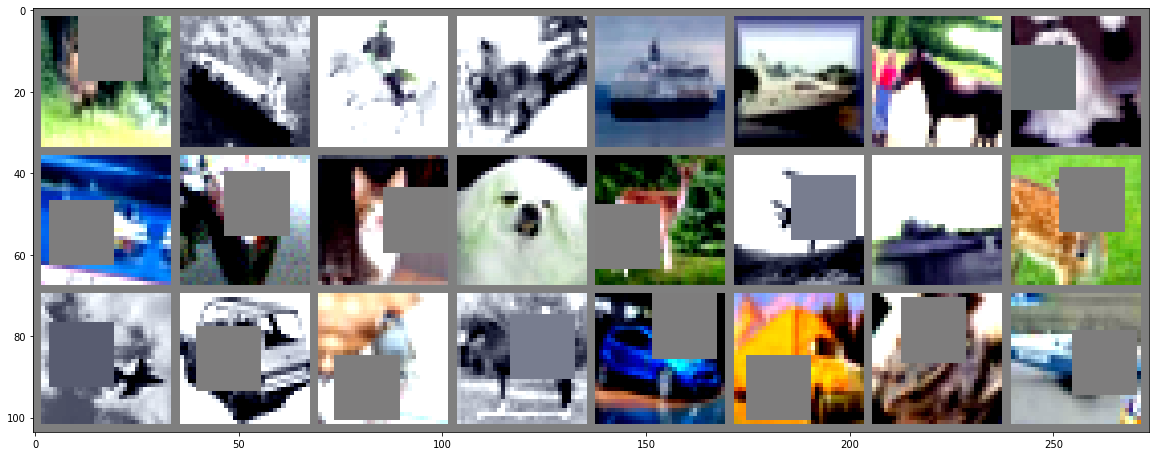

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
# get some random training images
dataiter = iter(cifar_dataset.train_loader)
images, labels = dataiter.next()

# show images
model_training.imshow(torchvision.utils.make_grid(images[:24]))

In [28]:
experiment_name = "cifar10-training"
epochs = 95
dropout = 0.01 ## increased from .01 - EXPERIMENT
model = model_cifar10.Net(dropout).to(device)

In [29]:
def model_summary(model, input_size=(3, 32, 32)):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(model)
  summary(model,input_size)


In [30]:
model_summary(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.01, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (5): Conv2d(32, 64, kernel_size=(1, 1),

In [31]:
exp_metrics={}

exp_metrics[experiment_name],model = run_experiments(device,
                                                       cifar_dataset,
                                                       epochs,
                                                       model)

# save_experiment(model,experiment_name)

Epoch 1:


Loss=1.8337123394012451 Batch_id=195 LR=0.00043 Accuracy=24.07: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0071, Accuracy: 3899/10000 (38.99%)

Epoch 2:


Loss=1.7042181491851807 Batch_id=195 LR=0.00052 Accuracy=37.80: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0063, Accuracy: 4781/10000 (47.81%)

Epoch 3:


Loss=1.733180284500122 Batch_id=195 LR=0.00066 Accuracy=44.39: 100%|██████████| 196/196 [00:26<00:00,  7.42it/s]



Test set: Average loss: 0.0056, Accuracy: 5480/10000 (54.80%)

Epoch 4:


Loss=1.7437212467193604 Batch_id=195 LR=0.00086 Accuracy=49.73: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0051, Accuracy: 5872/10000 (58.72%)

Epoch 5:


Loss=1.3798701763153076 Batch_id=195 LR=0.00111 Accuracy=52.74: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0048, Accuracy: 6020/10000 (60.20%)

Epoch 6:


Loss=1.315139889717102 Batch_id=195 LR=0.00141 Accuracy=55.95: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0044, Accuracy: 6342/10000 (63.42%)

Epoch 7:


Loss=1.2820134162902832 Batch_id=195 LR=0.00176 Accuracy=58.87: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0039, Accuracy: 6780/10000 (67.80%)

Epoch 8:


Loss=1.3094491958618164 Batch_id=195 LR=0.00215 Accuracy=60.54: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0038, Accuracy: 6893/10000 (68.93%)

Epoch 9:


Loss=1.0295288562774658 Batch_id=195 LR=0.00258 Accuracy=62.30: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0038, Accuracy: 6891/10000 (68.91%)

Epoch 10:


Loss=0.8397862315177917 Batch_id=195 LR=0.00303 Accuracy=63.53: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0041, Accuracy: 6598/10000 (65.98%)

Epoch 11:


Loss=1.006030797958374 Batch_id=195 LR=0.00352 Accuracy=64.75: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0037, Accuracy: 6849/10000 (68.49%)

Epoch 12:


Loss=0.8146241903305054 Batch_id=195 LR=0.00402 Accuracy=65.40: 100%|██████████| 196/196 [00:26<00:00,  7.40it/s]



Test set: Average loss: 0.0031, Accuracy: 7429/10000 (74.29%)

Epoch 13:


Loss=0.9492785334587097 Batch_id=195 LR=0.00454 Accuracy=66.17: 100%|██████████| 196/196 [00:26<00:00,  7.42it/s]



Test set: Average loss: 0.0031, Accuracy: 7322/10000 (73.22%)

Epoch 14:


Loss=1.1137462854385376 Batch_id=195 LR=0.00507 Accuracy=66.39: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0031, Accuracy: 7403/10000 (74.03%)

Epoch 15:


Loss=0.8237492442131042 Batch_id=195 LR=0.00560 Accuracy=67.31: 100%|██████████| 196/196 [00:26<00:00,  7.43it/s]



Test set: Average loss: 0.0031, Accuracy: 7355/10000 (73.55%)

Epoch 16:


Loss=1.1166660785675049 Batch_id=195 LR=0.00612 Accuracy=67.79: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0029, Accuracy: 7552/10000 (75.52%)

Epoch 17:


Loss=1.0921255350112915 Batch_id=195 LR=0.00663 Accuracy=67.86: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0029, Accuracy: 7514/10000 (75.14%)

Epoch 18:


Loss=0.8593747019767761 Batch_id=195 LR=0.00713 Accuracy=68.39: 100%|██████████| 196/196 [00:26<00:00,  7.43it/s]



Test set: Average loss: 0.0030, Accuracy: 7374/10000 (73.74%)

Epoch 19:


Loss=0.9844444394111633 Batch_id=195 LR=0.00760 Accuracy=69.19: 100%|██████████| 196/196 [00:26<00:00,  7.40it/s]



Test set: Average loss: 0.0032, Accuracy: 7281/10000 (72.81%)

Epoch 20:


Loss=1.0915096998214722 Batch_id=195 LR=0.00804 Accuracy=68.93: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0029, Accuracy: 7475/10000 (74.75%)

Epoch 21:


Loss=0.8692792654037476 Batch_id=195 LR=0.00845 Accuracy=69.29: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0028, Accuracy: 7627/10000 (76.27%)

Epoch 22:


Loss=0.955003559589386 Batch_id=195 LR=0.00882 Accuracy=69.45: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0029, Accuracy: 7489/10000 (74.89%)

Epoch 23:


Loss=0.8477927446365356 Batch_id=195 LR=0.00915 Accuracy=69.51: 100%|██████████| 196/196 [00:26<00:00,  7.42it/s]



Test set: Average loss: 0.0027, Accuracy: 7681/10000 (76.81%)

Epoch 24:


Loss=0.7892859578132629 Batch_id=195 LR=0.00942 Accuracy=69.71: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0029, Accuracy: 7493/10000 (74.93%)

Epoch 25:


Loss=0.8939248919487 Batch_id=195 LR=0.00965 Accuracy=69.97: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0033, Accuracy: 7243/10000 (72.43%)

Epoch 26:


Loss=0.8531785011291504 Batch_id=195 LR=0.00982 Accuracy=70.07: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0026, Accuracy: 7786/10000 (77.86%)

Epoch 27:


Loss=1.0856314897537231 Batch_id=195 LR=0.00993 Accuracy=70.64: 100%|██████████| 196/196 [00:26<00:00,  7.42it/s]



Test set: Average loss: 0.0036, Accuracy: 7044/10000 (70.44%)

Epoch 28:


Loss=1.1456373929977417 Batch_id=195 LR=0.00999 Accuracy=70.34: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0034, Accuracy: 7208/10000 (72.08%)

Epoch 29:


Loss=1.075331687927246 Batch_id=195 LR=0.01000 Accuracy=70.37: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0030, Accuracy: 7476/10000 (74.76%)

Epoch 30:


Loss=0.9881223440170288 Batch_id=195 LR=0.00999 Accuracy=70.38: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0029, Accuracy: 7618/10000 (76.18%)

Epoch 31:


Loss=0.9886752963066101 Batch_id=195 LR=0.00997 Accuracy=70.76: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0027, Accuracy: 7615/10000 (76.15%)

Epoch 32:


Loss=0.9022455215454102 Batch_id=195 LR=0.00993 Accuracy=70.93: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0028, Accuracy: 7552/10000 (75.52%)

Epoch 33:


Loss=0.9166707992553711 Batch_id=195 LR=0.00989 Accuracy=71.10: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0025, Accuracy: 7853/10000 (78.53%)

Epoch 34:


Loss=0.8106001615524292 Batch_id=195 LR=0.00983 Accuracy=71.00: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0029, Accuracy: 7624/10000 (76.24%)

Epoch 35:


Loss=0.8161551356315613 Batch_id=195 LR=0.00977 Accuracy=71.05: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0033, Accuracy: 7273/10000 (72.73%)

Epoch 36:


Loss=0.8689115643501282 Batch_id=195 LR=0.00969 Accuracy=71.04: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0028, Accuracy: 7608/10000 (76.08%)

Epoch 37:


Loss=0.732958197593689 Batch_id=195 LR=0.00960 Accuracy=71.34: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0025, Accuracy: 7884/10000 (78.84%)

Epoch 38:


Loss=0.8037557601928711 Batch_id=195 LR=0.00950 Accuracy=71.22: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0025, Accuracy: 7805/10000 (78.05%)

Epoch 39:


Loss=0.9890052676200867 Batch_id=195 LR=0.00940 Accuracy=71.57: 100%|██████████| 196/196 [00:26<00:00,  7.42it/s]



Test set: Average loss: 0.0030, Accuracy: 7418/10000 (74.18%)

Epoch 40:


Loss=0.7085970640182495 Batch_id=195 LR=0.00928 Accuracy=71.61: 100%|██████████| 196/196 [00:26<00:00,  7.40it/s]



Test set: Average loss: 0.0026, Accuracy: 7795/10000 (77.95%)

Epoch 41:


Loss=0.6468234062194824 Batch_id=195 LR=0.00915 Accuracy=71.58: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]



Test set: Average loss: 0.0024, Accuracy: 7932/10000 (79.32%)

Epoch 42:


Loss=0.8490002751350403 Batch_id=195 LR=0.00902 Accuracy=71.77: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0027, Accuracy: 7621/10000 (76.21%)

Epoch 43:


Loss=0.9128476977348328 Batch_id=195 LR=0.00887 Accuracy=71.97: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0027, Accuracy: 7706/10000 (77.06%)

Epoch 44:


Loss=0.8178725242614746 Batch_id=195 LR=0.00872 Accuracy=72.28: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0024, Accuracy: 7962/10000 (79.62%)

Epoch 45:


Loss=0.8195681571960449 Batch_id=195 LR=0.00856 Accuracy=72.10: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0026, Accuracy: 7828/10000 (78.28%)

Epoch 46:


Loss=0.6943470239639282 Batch_id=195 LR=0.00839 Accuracy=72.61: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0024, Accuracy: 7977/10000 (79.77%)

Epoch 47:


Loss=0.8309850692749023 Batch_id=195 LR=0.00821 Accuracy=72.30: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0027, Accuracy: 7692/10000 (76.92%)

Epoch 48:


Loss=0.6766585111618042 Batch_id=195 LR=0.00802 Accuracy=72.46: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]



Test set: Average loss: 0.0027, Accuracy: 7752/10000 (77.52%)

Epoch 49:


Loss=1.0532644987106323 Batch_id=195 LR=0.00783 Accuracy=73.02: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0027, Accuracy: 7721/10000 (77.21%)

Epoch 50:


Loss=0.8297349810600281 Batch_id=195 LR=0.00763 Accuracy=72.99: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0025, Accuracy: 7892/10000 (78.92%)

Epoch 51:


Loss=0.8353104591369629 Batch_id=195 LR=0.00743 Accuracy=73.20: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0023, Accuracy: 8027/10000 (80.27%)

Epoch 52:


Loss=0.9741862416267395 Batch_id=195 LR=0.00722 Accuracy=73.42: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]



Test set: Average loss: 0.0024, Accuracy: 7930/10000 (79.30%)

Epoch 53:


Loss=0.5614804625511169 Batch_id=195 LR=0.00701 Accuracy=73.45: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0024, Accuracy: 7947/10000 (79.47%)

Epoch 54:


Loss=0.8011579513549805 Batch_id=195 LR=0.00679 Accuracy=74.02: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0025, Accuracy: 7923/10000 (79.23%)

Epoch 55:


Loss=0.7982090711593628 Batch_id=195 LR=0.00657 Accuracy=73.97: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0024, Accuracy: 7999/10000 (79.99%)

Epoch 56:


Loss=0.77245032787323 Batch_id=195 LR=0.00634 Accuracy=73.90: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0022, Accuracy: 8166/10000 (81.66%)

Epoch 57:


Loss=0.7591160535812378 Batch_id=195 LR=0.00611 Accuracy=74.28: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0023, Accuracy: 8041/10000 (80.41%)

Epoch 58:


Loss=0.6082742810249329 Batch_id=195 LR=0.00588 Accuracy=74.43: 100%|██████████| 196/196 [00:26<00:00,  7.43it/s]



Test set: Average loss: 0.0023, Accuracy: 8031/10000 (80.31%)

Epoch 59:


Loss=0.77958083152771 Batch_id=195 LR=0.00565 Accuracy=74.65: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0022, Accuracy: 8144/10000 (81.44%)

Epoch 60:


Loss=0.885550856590271 Batch_id=195 LR=0.00541 Accuracy=75.05: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]



Test set: Average loss: 0.0022, Accuracy: 8085/10000 (80.85%)

Epoch 61:


Loss=0.7457245588302612 Batch_id=195 LR=0.00518 Accuracy=75.09: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0023, Accuracy: 8101/10000 (81.01%)

Epoch 62:


Loss=0.856988787651062 Batch_id=195 LR=0.00494 Accuracy=75.52: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]



Test set: Average loss: 0.0021, Accuracy: 8220/10000 (82.20%)

Epoch 63:


Loss=0.6839286088943481 Batch_id=195 LR=0.00470 Accuracy=75.79: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0021, Accuracy: 8148/10000 (81.48%)

Epoch 64:


Loss=0.5672301054000854 Batch_id=195 LR=0.00447 Accuracy=75.67: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Average loss: 0.0020, Accuracy: 8282/10000 (82.82%)

Epoch 65:


Loss=0.6435562372207642 Batch_id=195 LR=0.00423 Accuracy=75.97: 100%|██████████| 196/196 [00:27<00:00,  7.19it/s]



Test set: Average loss: 0.0021, Accuracy: 8241/10000 (82.41%)

Epoch 66:


Loss=0.5281286239624023 Batch_id=195 LR=0.00400 Accuracy=76.52: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0020, Accuracy: 8303/10000 (83.03%)

Epoch 67:


Loss=0.690117359161377 Batch_id=195 LR=0.00377 Accuracy=76.52: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0020, Accuracy: 8320/10000 (83.20%)

Epoch 68:


Loss=0.9565600156784058 Batch_id=195 LR=0.00354 Accuracy=76.71: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0019, Accuracy: 8381/10000 (83.81%)

Epoch 69:


Loss=0.49816450476646423 Batch_id=195 LR=0.00332 Accuracy=77.30: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0019, Accuracy: 8381/10000 (83.81%)

Epoch 70:


Loss=0.7226431965827942 Batch_id=195 LR=0.00310 Accuracy=77.39: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0019, Accuracy: 8368/10000 (83.68%)

Epoch 71:


Loss=0.6356824636459351 Batch_id=195 LR=0.00288 Accuracy=77.83: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0019, Accuracy: 8365/10000 (83.65%)

Epoch 72:


Loss=0.6859714388847351 Batch_id=195 LR=0.00267 Accuracy=77.94: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0018, Accuracy: 8436/10000 (84.36%)

Epoch 73:


Loss=0.6100456714630127 Batch_id=195 LR=0.00246 Accuracy=78.46: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0018, Accuracy: 8421/10000 (84.21%)

Epoch 74:


Loss=0.6661063432693481 Batch_id=195 LR=0.00226 Accuracy=78.57: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]



Test set: Average loss: 0.0018, Accuracy: 8495/10000 (84.95%)

Epoch 75:


Loss=0.645595133304596 Batch_id=195 LR=0.00207 Accuracy=78.71: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0018, Accuracy: 8495/10000 (84.95%)

Epoch 76:


Loss=0.7277189493179321 Batch_id=195 LR=0.00188 Accuracy=78.87: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0017, Accuracy: 8514/10000 (85.14%)

Epoch 77:


Loss=0.5693426728248596 Batch_id=195 LR=0.00170 Accuracy=79.25: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8504/10000 (85.04%)

Epoch 78:


Loss=0.49850964546203613 Batch_id=195 LR=0.00153 Accuracy=79.43: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0017, Accuracy: 8509/10000 (85.09%)

Epoch 79:


Loss=0.6522964239120483 Batch_id=195 LR=0.00136 Accuracy=79.59: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0017, Accuracy: 8567/10000 (85.67%)

Epoch 80:


Loss=0.5523295998573303 Batch_id=195 LR=0.00120 Accuracy=79.81: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8552/10000 (85.52%)

Epoch 81:


Loss=0.5941554307937622 Batch_id=195 LR=0.00105 Accuracy=80.24: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8590/10000 (85.90%)

Epoch 82:


Loss=0.6956799626350403 Batch_id=195 LR=0.00091 Accuracy=80.22: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8584/10000 (85.84%)

Epoch 83:


Loss=0.5770138502120972 Batch_id=195 LR=0.00078 Accuracy=80.60: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]



Test set: Average loss: 0.0016, Accuracy: 8634/10000 (86.34%)

Epoch 84:


Loss=0.6695526838302612 Batch_id=195 LR=0.00066 Accuracy=80.61: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8595/10000 (85.95%)

Epoch 85:


Loss=0.48073941469192505 Batch_id=195 LR=0.00055 Accuracy=80.91: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]



Test set: Average loss: 0.0016, Accuracy: 8624/10000 (86.24%)

Epoch 86:


Loss=0.4539763331413269 Batch_id=195 LR=0.00044 Accuracy=81.02: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

Epoch 87:


Loss=0.5293794870376587 Batch_id=195 LR=0.00035 Accuracy=81.31: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8671/10000 (86.71%)

Epoch 88:


Loss=0.5300928950309753 Batch_id=195 LR=0.00027 Accuracy=81.43: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8679/10000 (86.79%)

Epoch 89:


Loss=0.6882849931716919 Batch_id=195 LR=0.00020 Accuracy=81.60: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8656/10000 (86.56%)

Epoch 90:


Loss=0.43820643424987793 Batch_id=195 LR=0.00014 Accuracy=81.72: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0016, Accuracy: 8692/10000 (86.92%)

Epoch 91:


Loss=0.5746750235557556 Batch_id=195 LR=0.00009 Accuracy=81.82: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8675/10000 (86.75%)

Epoch 92:


Loss=0.4375040531158447 Batch_id=195 LR=0.00005 Accuracy=81.54: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8689/10000 (86.89%)

Epoch 93:


Loss=0.6666744947433472 Batch_id=195 LR=0.00002 Accuracy=81.54: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0015, Accuracy: 8677/10000 (86.77%)

Epoch 94:


Loss=0.3979238271713257 Batch_id=195 LR=0.00001 Accuracy=81.78: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8688/10000 (86.88%)

Epoch 95:


Loss=0.6644643545150757 Batch_id=195 LR=0.00000 Accuracy=81.92: 100%|██████████| 196/196 [00:27<00:00,  7.26it/s]



Test set: Average loss: 0.0015, Accuracy: 8685/10000 (86.85%)



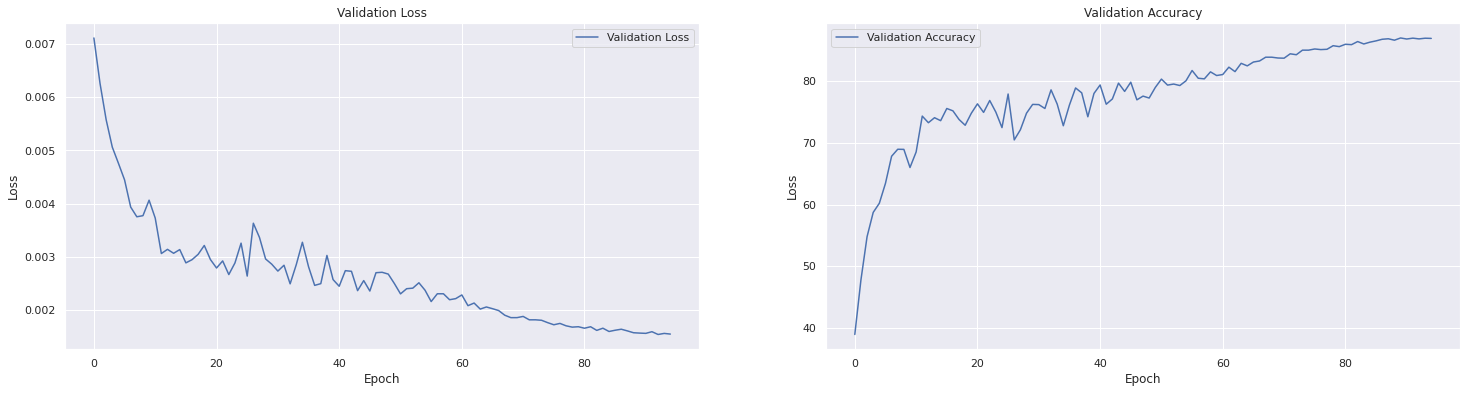

In [32]:
helper_functions.plot_metrics(exp_metrics[experiment_name])     

In [33]:
# experiment_name = "cifar10-training-finetune"
# epochs = 20
# dropout = 0.01 ## increased from .01 - EXPERIMENT
# model = Net(dropout).to(device)

# exp_metrics={}

# exp_metrics[experiment_name],model = run_experiments(device,
#                                                        cifar_dataset,
#                                                        epochs,
#                                                        model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


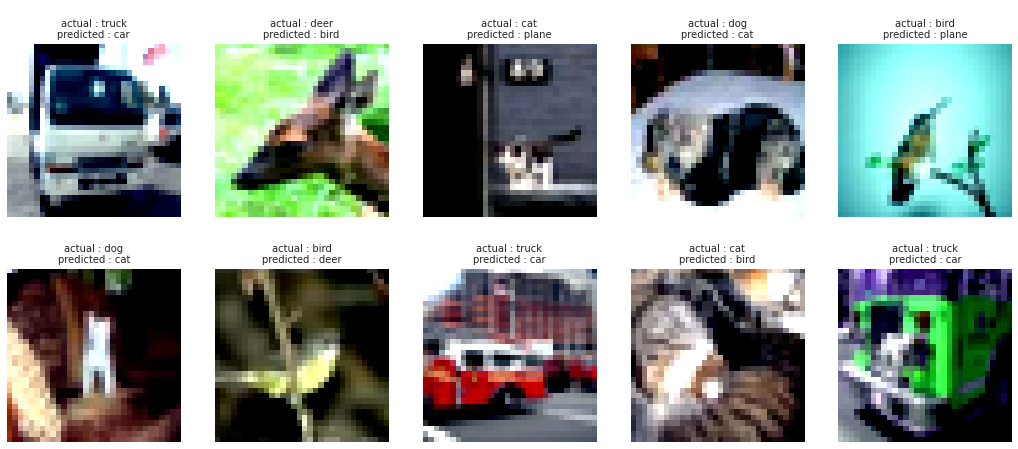

In [35]:
# model = torch.load(f'./saved_models/{experiment_name}.pt')
model.eval()
helper_functions.wrong_predictions(cifar_dataset.test_loader,
                  use_cuda,
                  model)

In [36]:
helper_functions.class_level_accuracy(model, cifar_dataset.test_loader, device)

Accuracy of airplane : 93 %
Accuracy of automobile : 94 %
Accuracy of  bird : 92 %
Accuracy of   cat : 63 %
Accuracy of  deer : 91 %
Accuracy of   dog : 84 %
Accuracy of  frog : 90 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 78 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

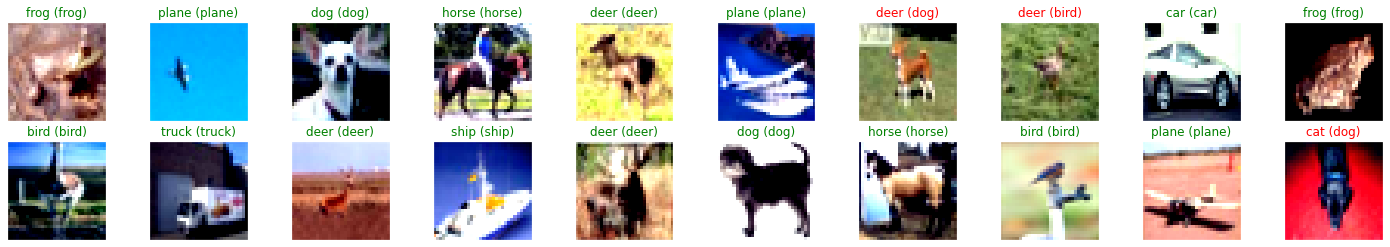

In [37]:
model_training.visualize_sample_test_result(model, 
                             cifar_dataset.test_loader,
                             use_cuda)

In [38]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=193722201c1fc0a1748cb2771812d05e14681ea05646700d9422fe06400a61d3
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [39]:
model = model.to(device)

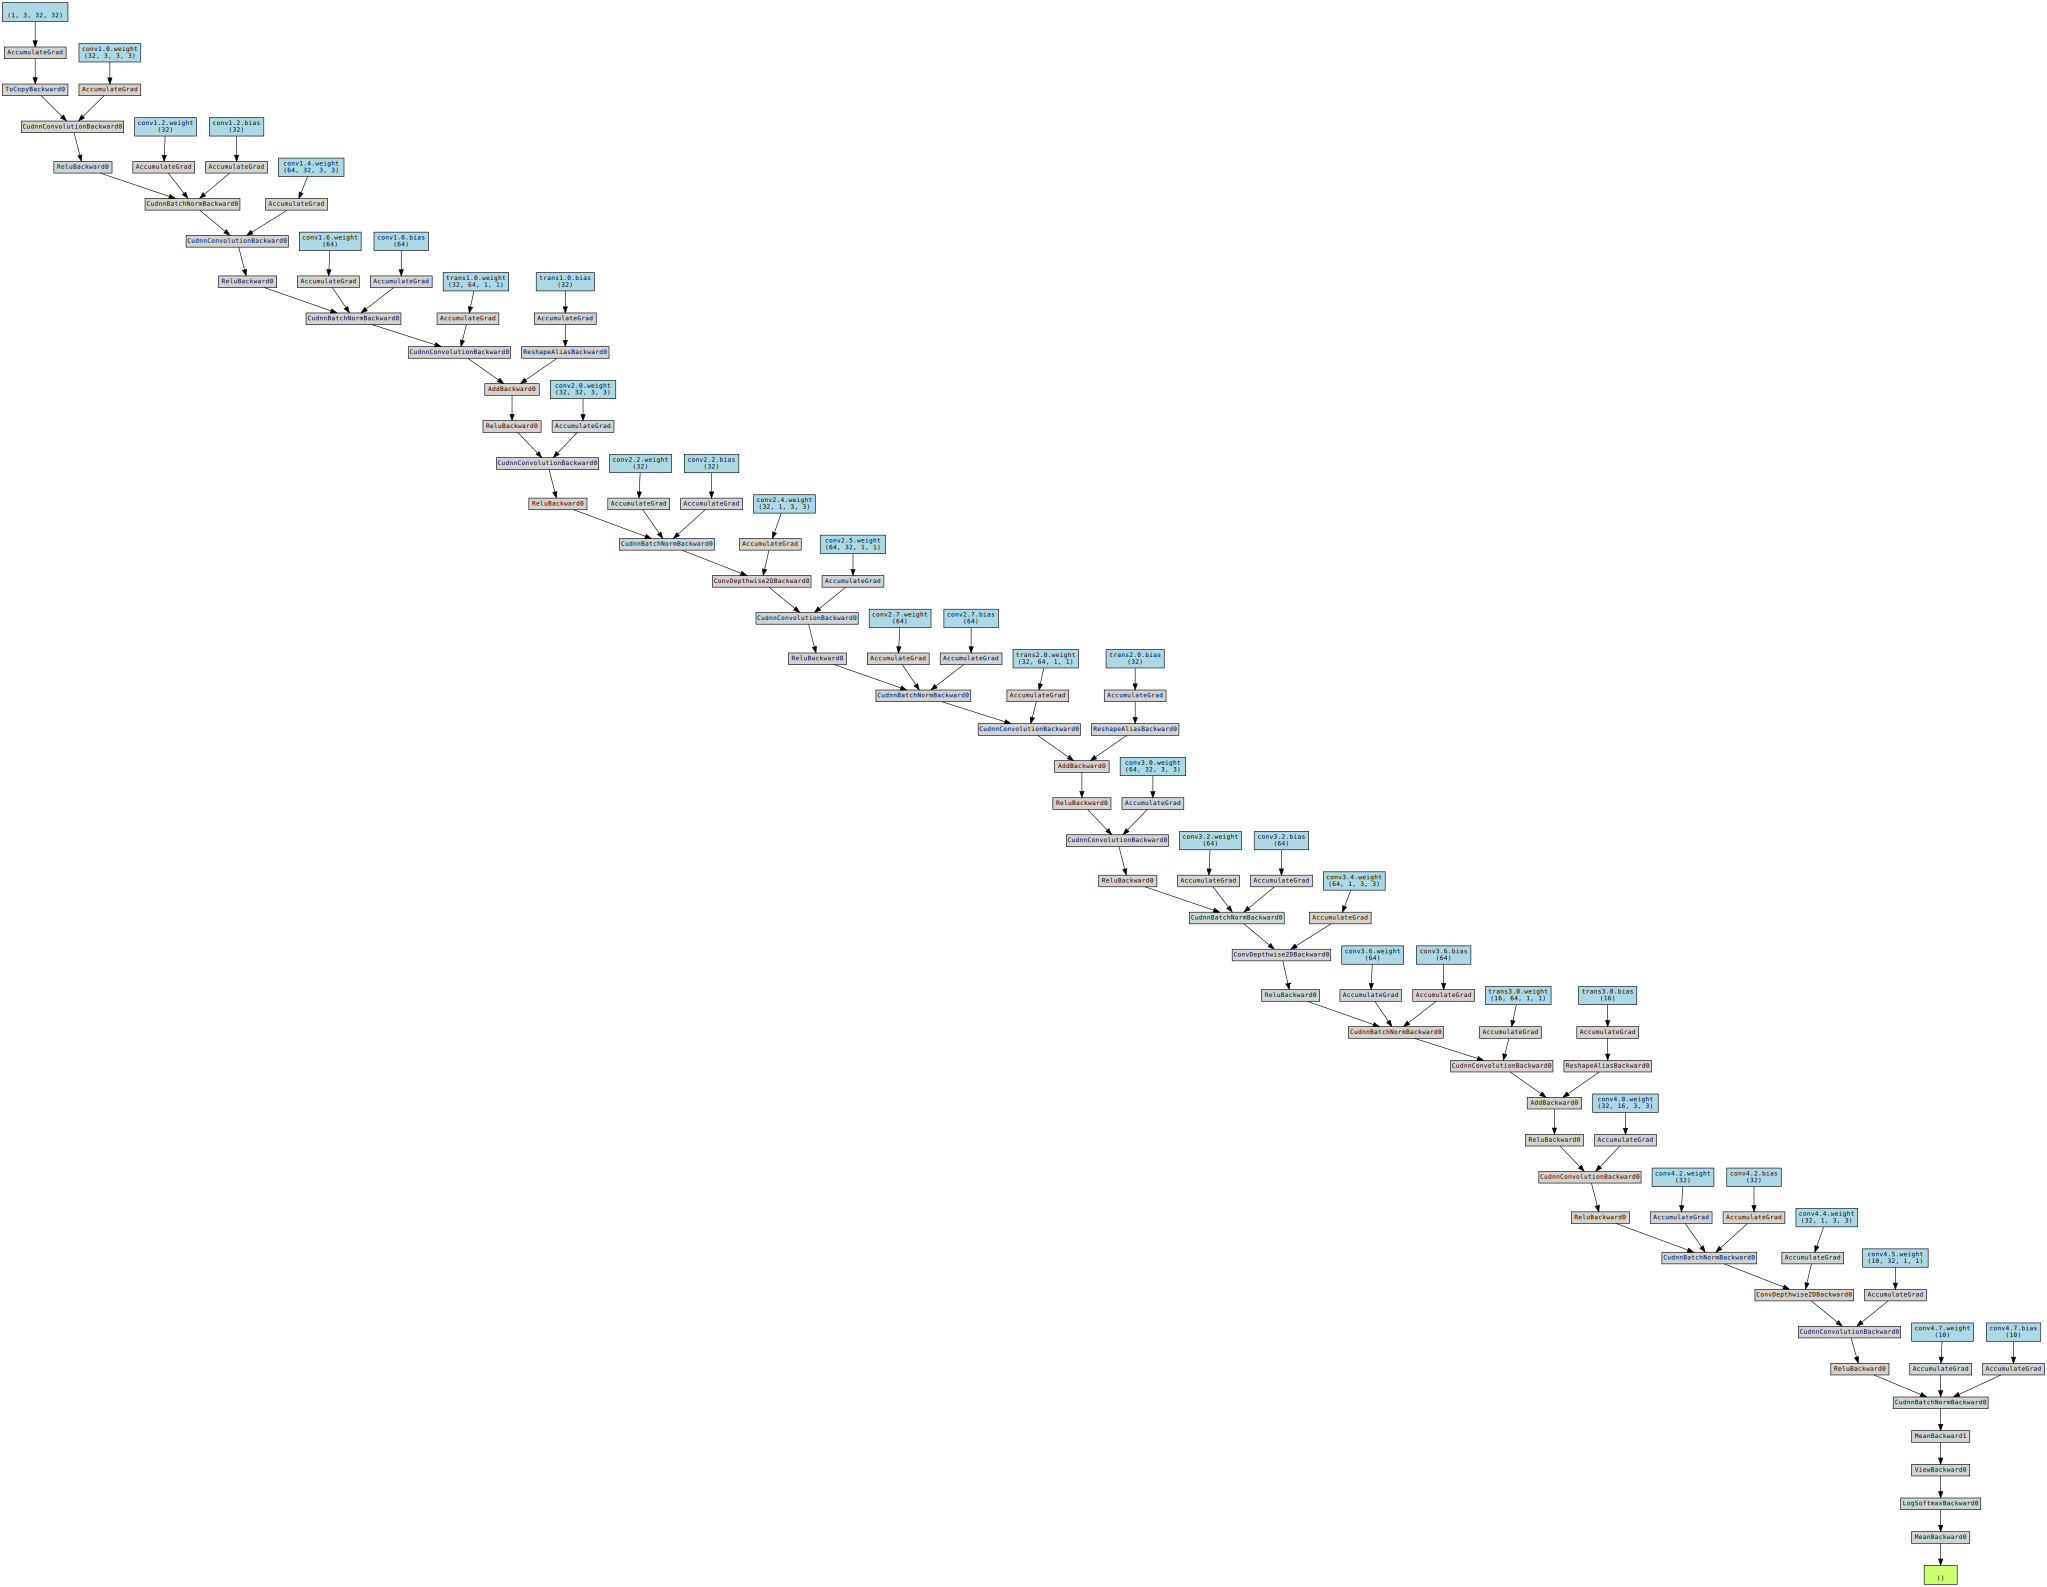

In [40]:
 from torchviz import make_dot
 x = torch.randn(1, 3, 32, 32).requires_grad_(True).cuda()
 y = model(x)   
 MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
 MyConvNetVis.format = "png"
 MyConvNetVis.directory = "data"
 MyConvNetVis.view()
 make_dot(y.mean(), params=dict(model.named_parameters()))
